# Project 3: Project #GetWellPlan
---

**Organization of Project Notebooks:**
- Notebook #1: [Problem Statement & Webscrapping](./01_problem_statement_and_webscrapping.ipynb)
- Notebook #2: [Data Cleaning & Exploratory Data Analysis](./02_data_cleaning_and_eda.ipynb)
- **Notebook #3: Preprocessing & Modelling** (current notebook) 
- Notebook #4: [Sentiment Analysis & Recommendations](./04_sentiment_analysis_and_recommendations.ipynb)

## Notebook #3: Preprocessing & Modelling

### Contents
- [1. Introduction](#1.-Introduction)
- [2. Data Preparation](#2.-Data-Preparation)
- [3. Obtaining a Baseline Score](#3.-Obtaining-a-Baseline-Score)
- [4. Additional Data Preparation & Visualization](#4.-Additional-Data-Preparation-&-Visualization)
- [5. Modelling](#5.-Modelling)
- [6. Evaluation of Model & Vectorizer Performance](#6.-Evaluation-of-Model-&-Vectorizer-Performance)
- [7. Creating Predictions with the Selected Model & Vectorizer](#7.-Creating-Predictions-with-the-Selected-Model-&-Vectorizer) 

### 1. Introduction

In this notebook, we will be using the cleaned data obtained from the [previous notebook](./02_data_cleaning_and_eda.ipynb), to build a model that will classify whether a post belongs to Walmart or Costco. A combination of vectorizers and models will be utilized to train the dataset set aside for training, and they will be evaluated based on metrics such as accuracy score, recall score, precision score, F1 score, and ROC AUC score. This includes: 
- Choice of `vectorizer`: 
    - Count Vectorizer
    - TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer
    
    
- Choice of `model`: 
    - Logistic Regression
    - Multinomial Naive Bayes
    - Random Forest Classifier
    - Support Vector Classifier


Thereafter, the best performing model will finetuned further, and utilized to predict the test dataset.

In [1]:
# import the relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 2. Data Preparation

For this section, we will be subjecting the combined dataset (containing posts from Walmart and Costco subreddits) for further cleaning, to prepare it for the upcoming training and testing of the vectorizers and models.

In [2]:
# read in the combined DataFrame
combined_df = pd.read_csv('datasets/combined.csv')

In [3]:
# view the top 5 rows in the combined DataFrame
combined_df.head()

,Unnamed: 0,author,created_utc,id,num_comments,score,selftext,subreddit,title,url,title_char_len,title_word_count
0,0,armoreddillo,2020-11-21 13:11:36,jy56so,434,4912,👆,walmart,"If you're here, as a customer, to complain abo...",https://www.reddit.com/r/walmart/comments/jy56...,87,14
1,1,jasiad,2021-06-08 23:53:14,nv7aao,28,18,"Disclaimer: Don't be disrespectful, don't be r...",walmart,Weekly Salt Thread 207 - The Nintendo Switch N...,https://www.reddit.com/r/walmart/comments/nv7a...,66,13
2,2,MadHatler,2021-06-10 06:33:11,nw89f8,47,481,nothinghere,walmart,How do y’all pay bills,https://i.redd.it/s12ll09dhb471.jpg,22,5
3,3,KVirello,2021-06-10 06:51:44,nw8n27,28,183,My entire adult life I have never worked Sunda...,walmart,Just promoted myself to customer halfway throu...,https://www.reddit.com/r/walmart/comments/nw8n...,98,16
4,4,-_Trashboat,2021-06-10 00:28:46,nvzzf2,48,454,nothinghere,walmart,DC Tips & Tricks #37: Make Sure Your Pallet Ha...,https://i.imgur.com/Lu5oNZ5.jpg,94,19


In [4]:
# drop the first unnamed column
combined_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# check if there are null values in the 'title column'
combined_df['title'].isnull().sum()

0

In [6]:
# view the proportion of posts between Costco and Walmart 
combined_df['subreddit'].value_counts(normalize=True)

Costco     0.512915
walmart    0.487085
Name: subreddit, dtype: float64

In [7]:
# since there's a slightly higher proportion of Costco's posts
# assign the Walmart posts to class 0 and Costco posts to class 1 in the 'subreddit' column
combined_df['subreddit'] = combined_df['subreddit'].apply(lambda x:1 if x=='Costco' else 0)

In [8]:
# create a new DataFrame containing just 'title' and 'subreddit'
titles_df = combined_df[['title', 'subreddit']]

In [9]:
# view the top 5 rows in the new DataFrame
titles_df.head()

,title,subreddit
0,"If you're here, as a customer, to complain abo...",0
1,Weekly Salt Thread 207 - The Nintendo Switch N...,0
2,How do y’all pay bills,0
3,Just promoted myself to customer halfway throu...,0
4,DC Tips & Tricks #37: Make Sure Your Pallet Ha...,0


In [10]:
# view the shape of the new DataFrame
titles_df.shape

(1897, 2)

### 3. Obtaining a Baseline Score

To validate the performance of subsequent models to be created, we will first compute the baseline score. 

In [11]:
# compute a baseline score
titles_df['subreddit'].value_counts(normalize=True)

1    0.512915
0    0.487085
Name: subreddit, dtype: float64

- From the combined dataset, we observe that 51.2% of the posts belong to Costco, while the remaining 48.8% belong to Walmart.
- Therefore, the baseline score (accuracy) is 51.2%, and all subsequent models need to perform better than this value to be considered for the final classification modelling.

### 4. Additional Data Preparation & Visualization

While going through the titles earlier, it can be observed that:
- The titles contain a mixture of uppercase and lowercase words – we will need to change all wordings to lowercase. 
- Some titles contain various punctuations and emojis – we will need to remove these variations. 
- Some titles contain numerical values – since we will be analyzing text, we will need to remove the numerical values. 
- Some titles contain website URLs – we will need to remove the URLs. 

We will use Lemmatizing over Stemming, to return the lemma form of the words, i.e. similar to the base/dictionary form of a word. It is less crude than Stemming, which may result in various irregularities in English. 

In [12]:
# change all words to lowercase
titles_df['title_lower'] = titles_df['title'].apply(lambda x: x.lower())

In [13]:
# instantiate the lemmatizier and tokenizer
# retain only word characters
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# set up the lemmatizer
lemmatized_posts = []
for post in titles_df['title_lower']:
    tokens = tokenizer.tokenize(post)
    post = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(' '.join(post))
    
# append the lemmatized posts to the DataFrame
titles_df['title_lemmatized'] = lemmatized_posts

In [14]:
# remove all numerical values
titles_df['title_lemmatized'].replace('\d+', '', regex=True, inplace=True)

In [15]:
# remove URL
titles_df['title_lemmatized'].str.replace('http\S+','')

0       if you re here a a customer to complain about ...
1       weekly salt thread  the nintendo switch no is ...
2                                   how do y all pay bill
3       just promoted myself to customer halfway throu...
4       dc tip trick  make sure your pallet ha a stron...
                              ...                        
1892                                     cutie on a k bed
1893    looking for a treadmill doe costco offer free ...
1894    deli prepared kirkland mac and cheese longevit...
1895    did costco photo department discontinue sellin...
1896                                         crisper tray
Name: title_lemmatized, Length: 1897, dtype: object

In [16]:
# view the top 5 rows in the DataFrame
titles_df.head()

,title,subreddit,title_lower,title_lemmatized
0,"If you're here, as a customer, to complain abo...",0,"if you're here, as a customer, to complain abo...",if you re here a a customer to complain about ...
1,Weekly Salt Thread 207 - The Nintendo Switch N...,0,weekly salt thread 207 - the nintendo switch n...,weekly salt thread the nintendo switch no is ...
2,How do y’all pay bills,0,how do y’all pay bills,how do y all pay bill
3,Just promoted myself to customer halfway throu...,0,just promoted myself to customer halfway throu...,just promoted myself to customer halfway throu...
4,DC Tips & Tricks #37: Make Sure Your Pallet Ha...,0,dc tips & tricks #37: make sure your pallet ha...,dc tip trick make sure your pallet ha a stron...


In [17]:
# view the bottom 5 rows in the DataFrame
titles_df.tail()

,title,subreddit,title_lower,title_lemmatized
1892,Cutie on a KS bed,1,cutie on a ks bed,cutie on a k bed
1893,"Looking for a treadmill, does Costco offer fre...",1,"looking for a treadmill, does costco offer fre...",looking for a treadmill doe costco offer free ...
1894,Deli Prepared Kirkland Mac and Cheese longevit...,1,deli prepared kirkland mac and cheese longevit...,deli prepared kirkland mac and cheese longevit...
1895,Did Costco Photo Department discontinue sellin...,1,did costco photo department discontinue sellin...,did costco photo department discontinue sellin...
1896,Crisper Tray,1,crisper tray,crisper tray


#### Exploring the most commonly occurring one-word in Walmart and Costco after lemmatization

In [18]:
# instantiate CountVectorizer (one-word, with stop words removed)
cvec = CountVectorizer(stop_words='english')

# Walmart - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
walmart_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==0]['title_lemmatized'])
print('No. of features in Walmart after removing stop words: {}'.format(len(cvec.get_feature_names())))
walmart_cvec = pd.DataFrame(walmart_cvec.toarray(), 
                            columns = cvec.get_feature_names())
walmart_title_lem = walmart_cvec.sum().sort_values(ascending=False).head(50)

# Costco - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
costco_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==1]['title_lemmatized'])
print('No. of features in Costco after removing stop words: {}'.format(len(cvec.get_feature_names())))
costco_cvec = pd.DataFrame(costco_cvec.toarray(), 
                           columns = cvec.get_feature_names())
costco_title_lem = costco_cvec.sum().sort_values(ascending=False).head(50)

No. of features in Walmart after removing stop words: 1514
No. of features in Costco after removing stop words: 2178


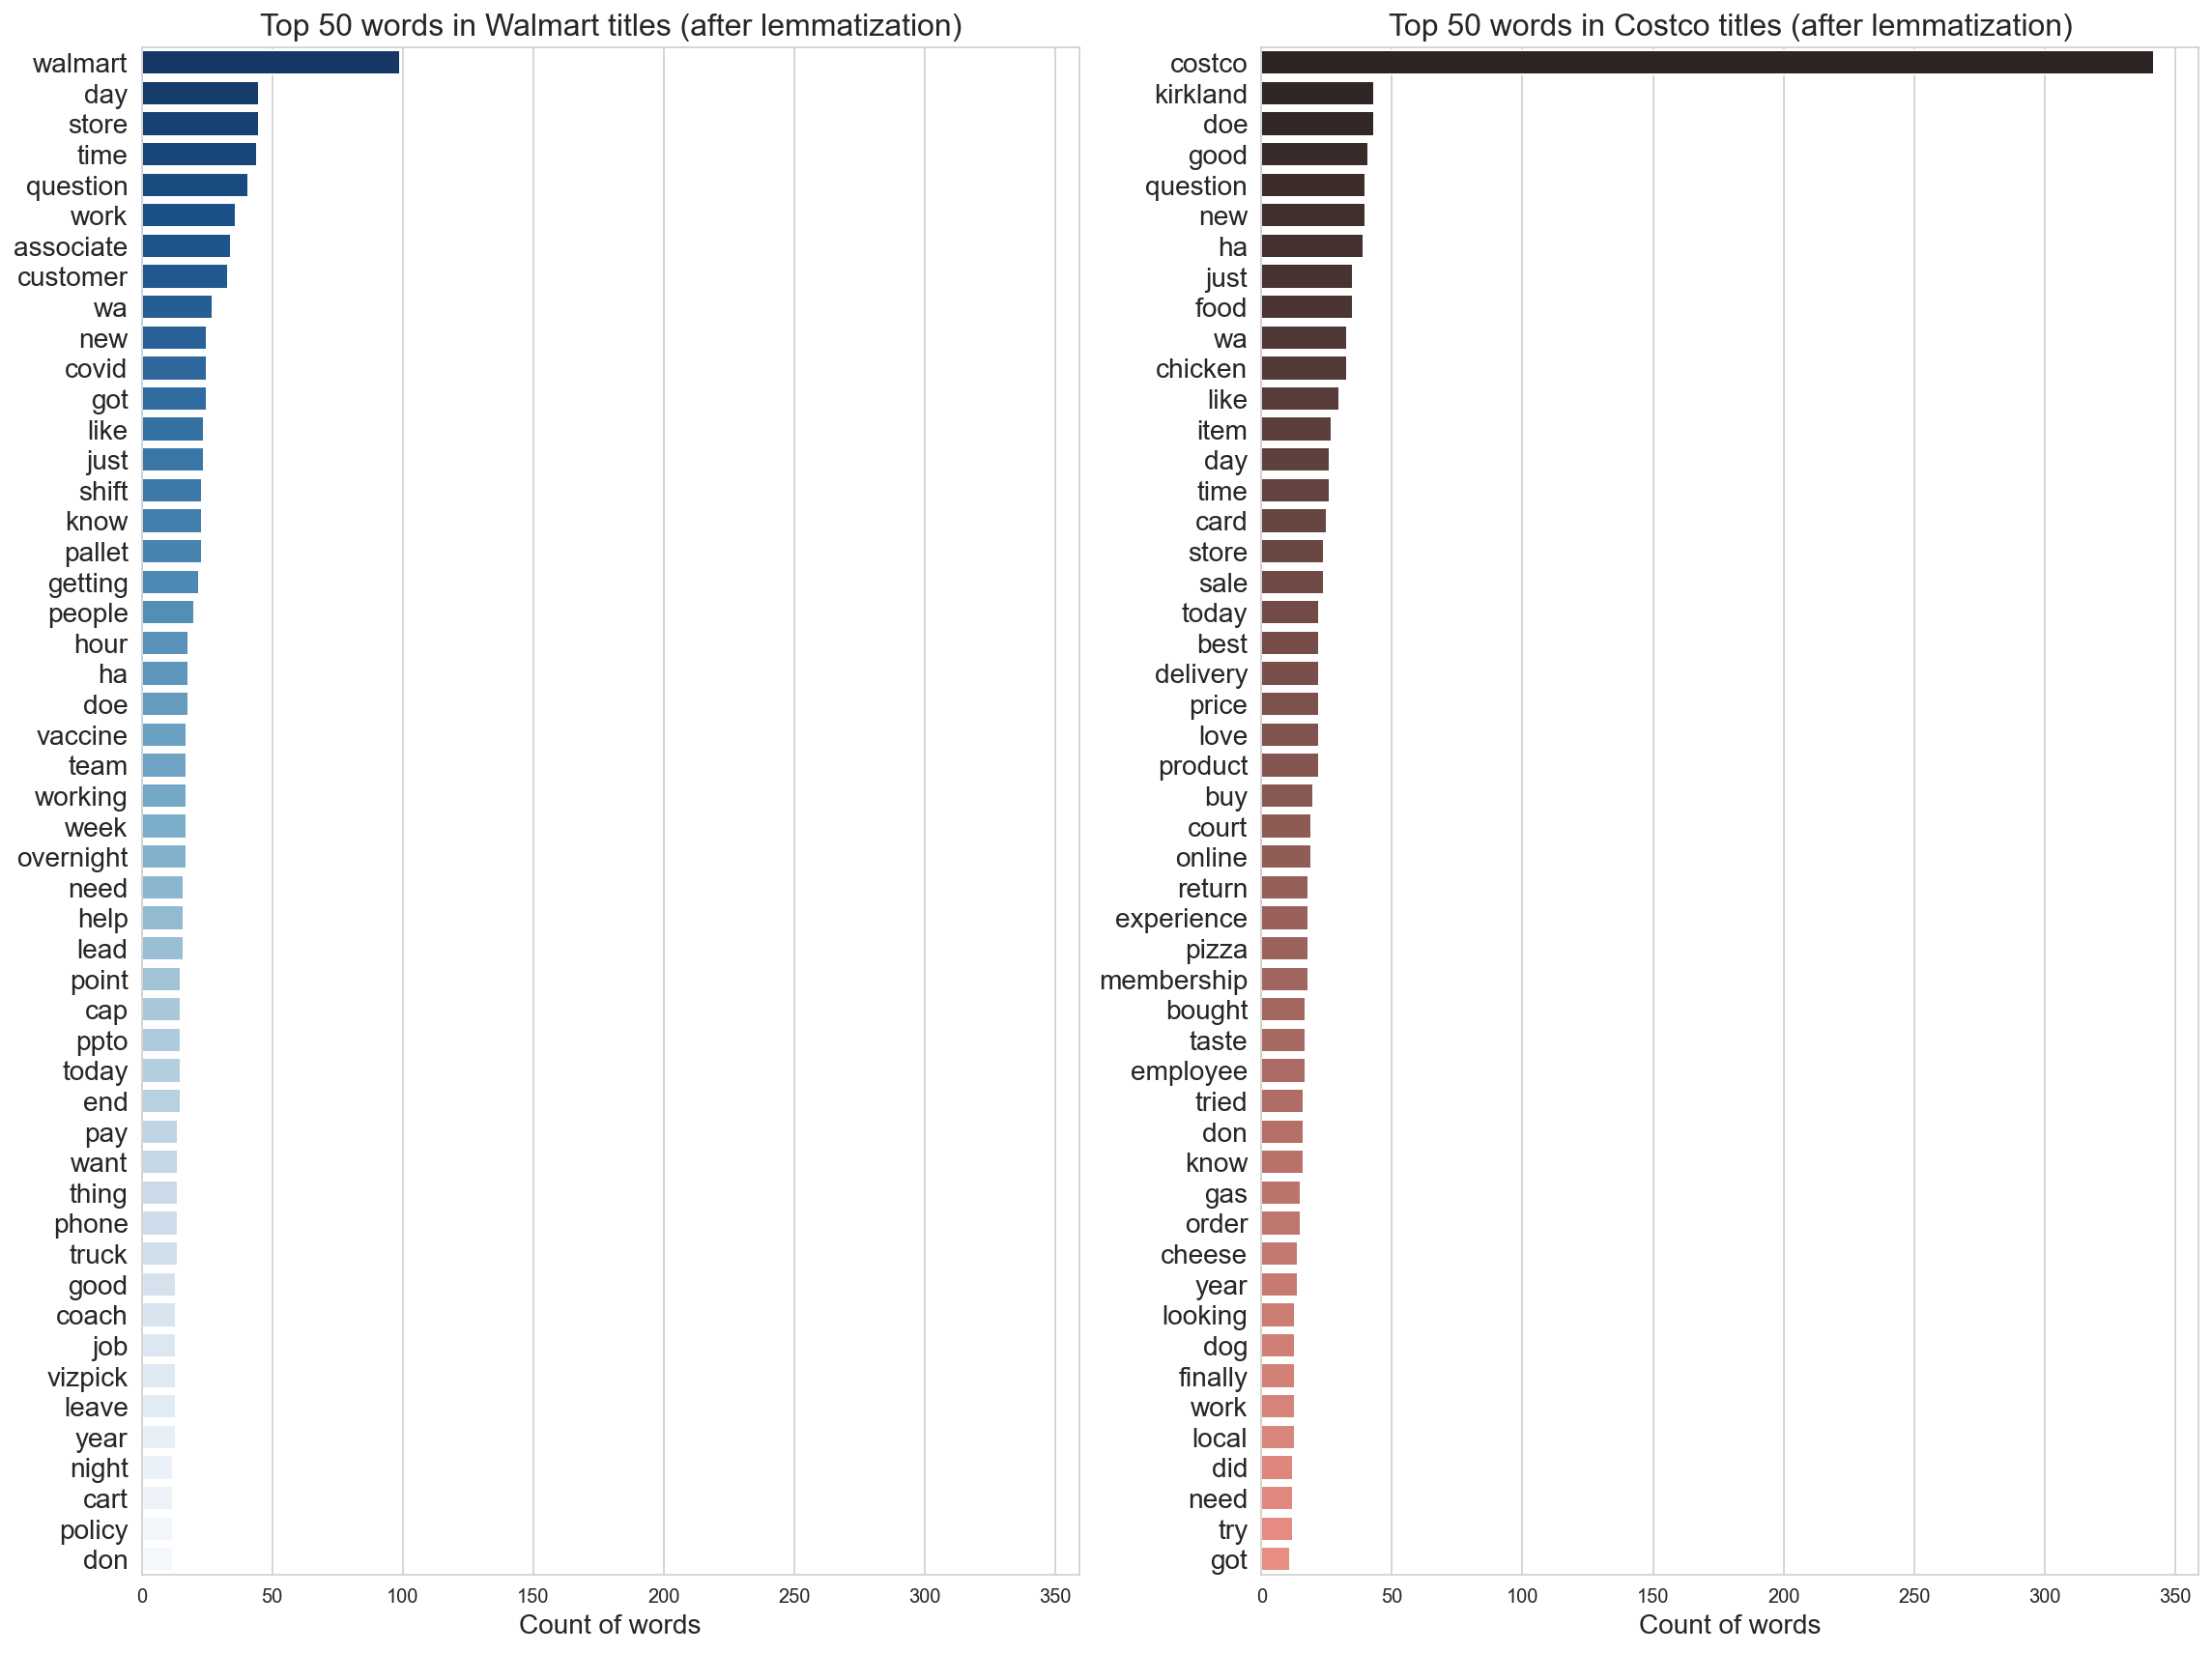

In [19]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,12), sharex=True)

# plot results for Walmart
sns.barplot(y=walmart_title_lem.index.values, x=walmart_title_lem, palette='Blues_r', ax=ax[0])
ax[0].set_title('Top 50 words in Walmart titles (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Costco
sns.barplot(y=costco_title_lem.index.values, x=costco_title_lem, palette='dark:salmon', ax=ax[1])
ax[1].set_title('Top 50 words in Costco titles (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

Earlier, we have identified that: 
- Words that allow for easy recognition of the brands, such as 'walmart', 'costco' and 'kirkland', will need to be added to the list of stop words, so as to enhance the model's classification ability.
- Other words that appear commonly in both subreddits such as 'just', 'like' and 'got' will also need to be added to the list of stop words, as they do not aid in the classification of whether a post belongs to Walmart or Costco.

In [20]:
# add additional stopwords to the english set
new_stopwords = ['walmart', 'just', 'like', 'doe', 'wa', 'ha', 'costco', 'wal', 'mart', 'got', 'kirkland']
model_stopwords = stopwords.words('english')
model_stopwords.extend(new_stopwords)

#### Exploring the most commonly occurring one-word in Walmart and Costco after lemmatization and addition of new stop words

In [21]:
# instantiate CountVectorizer (one-word, with stop words removed)
cvec = CountVectorizer(stop_words=model_stopwords)

# Walmart - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
walmart_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==0]['title_lemmatized'])
print('No. of features in Walmart after removing stop words: {}'.format(len(cvec.get_feature_names())))
walmart_cvec = pd.DataFrame(walmart_cvec.toarray(), 
                            columns = cvec.get_feature_names())
walmart_title_lem = walmart_cvec.sum().sort_values(ascending=False).head(50)

# Costco - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
costco_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==1]['title_lemmatized'])
print('No. of features in Costco after removing stop words: {}'.format(len(cvec.get_feature_names())))
costco_cvec = pd.DataFrame(costco_cvec.toarray(), 
                           columns = cvec.get_feature_names())
costco_title_lem = costco_cvec.sum().sort_values(ascending=False).head(50)

No. of features in Walmart after removing stop words: 1590
No. of features in Costco after removing stop words: 2247


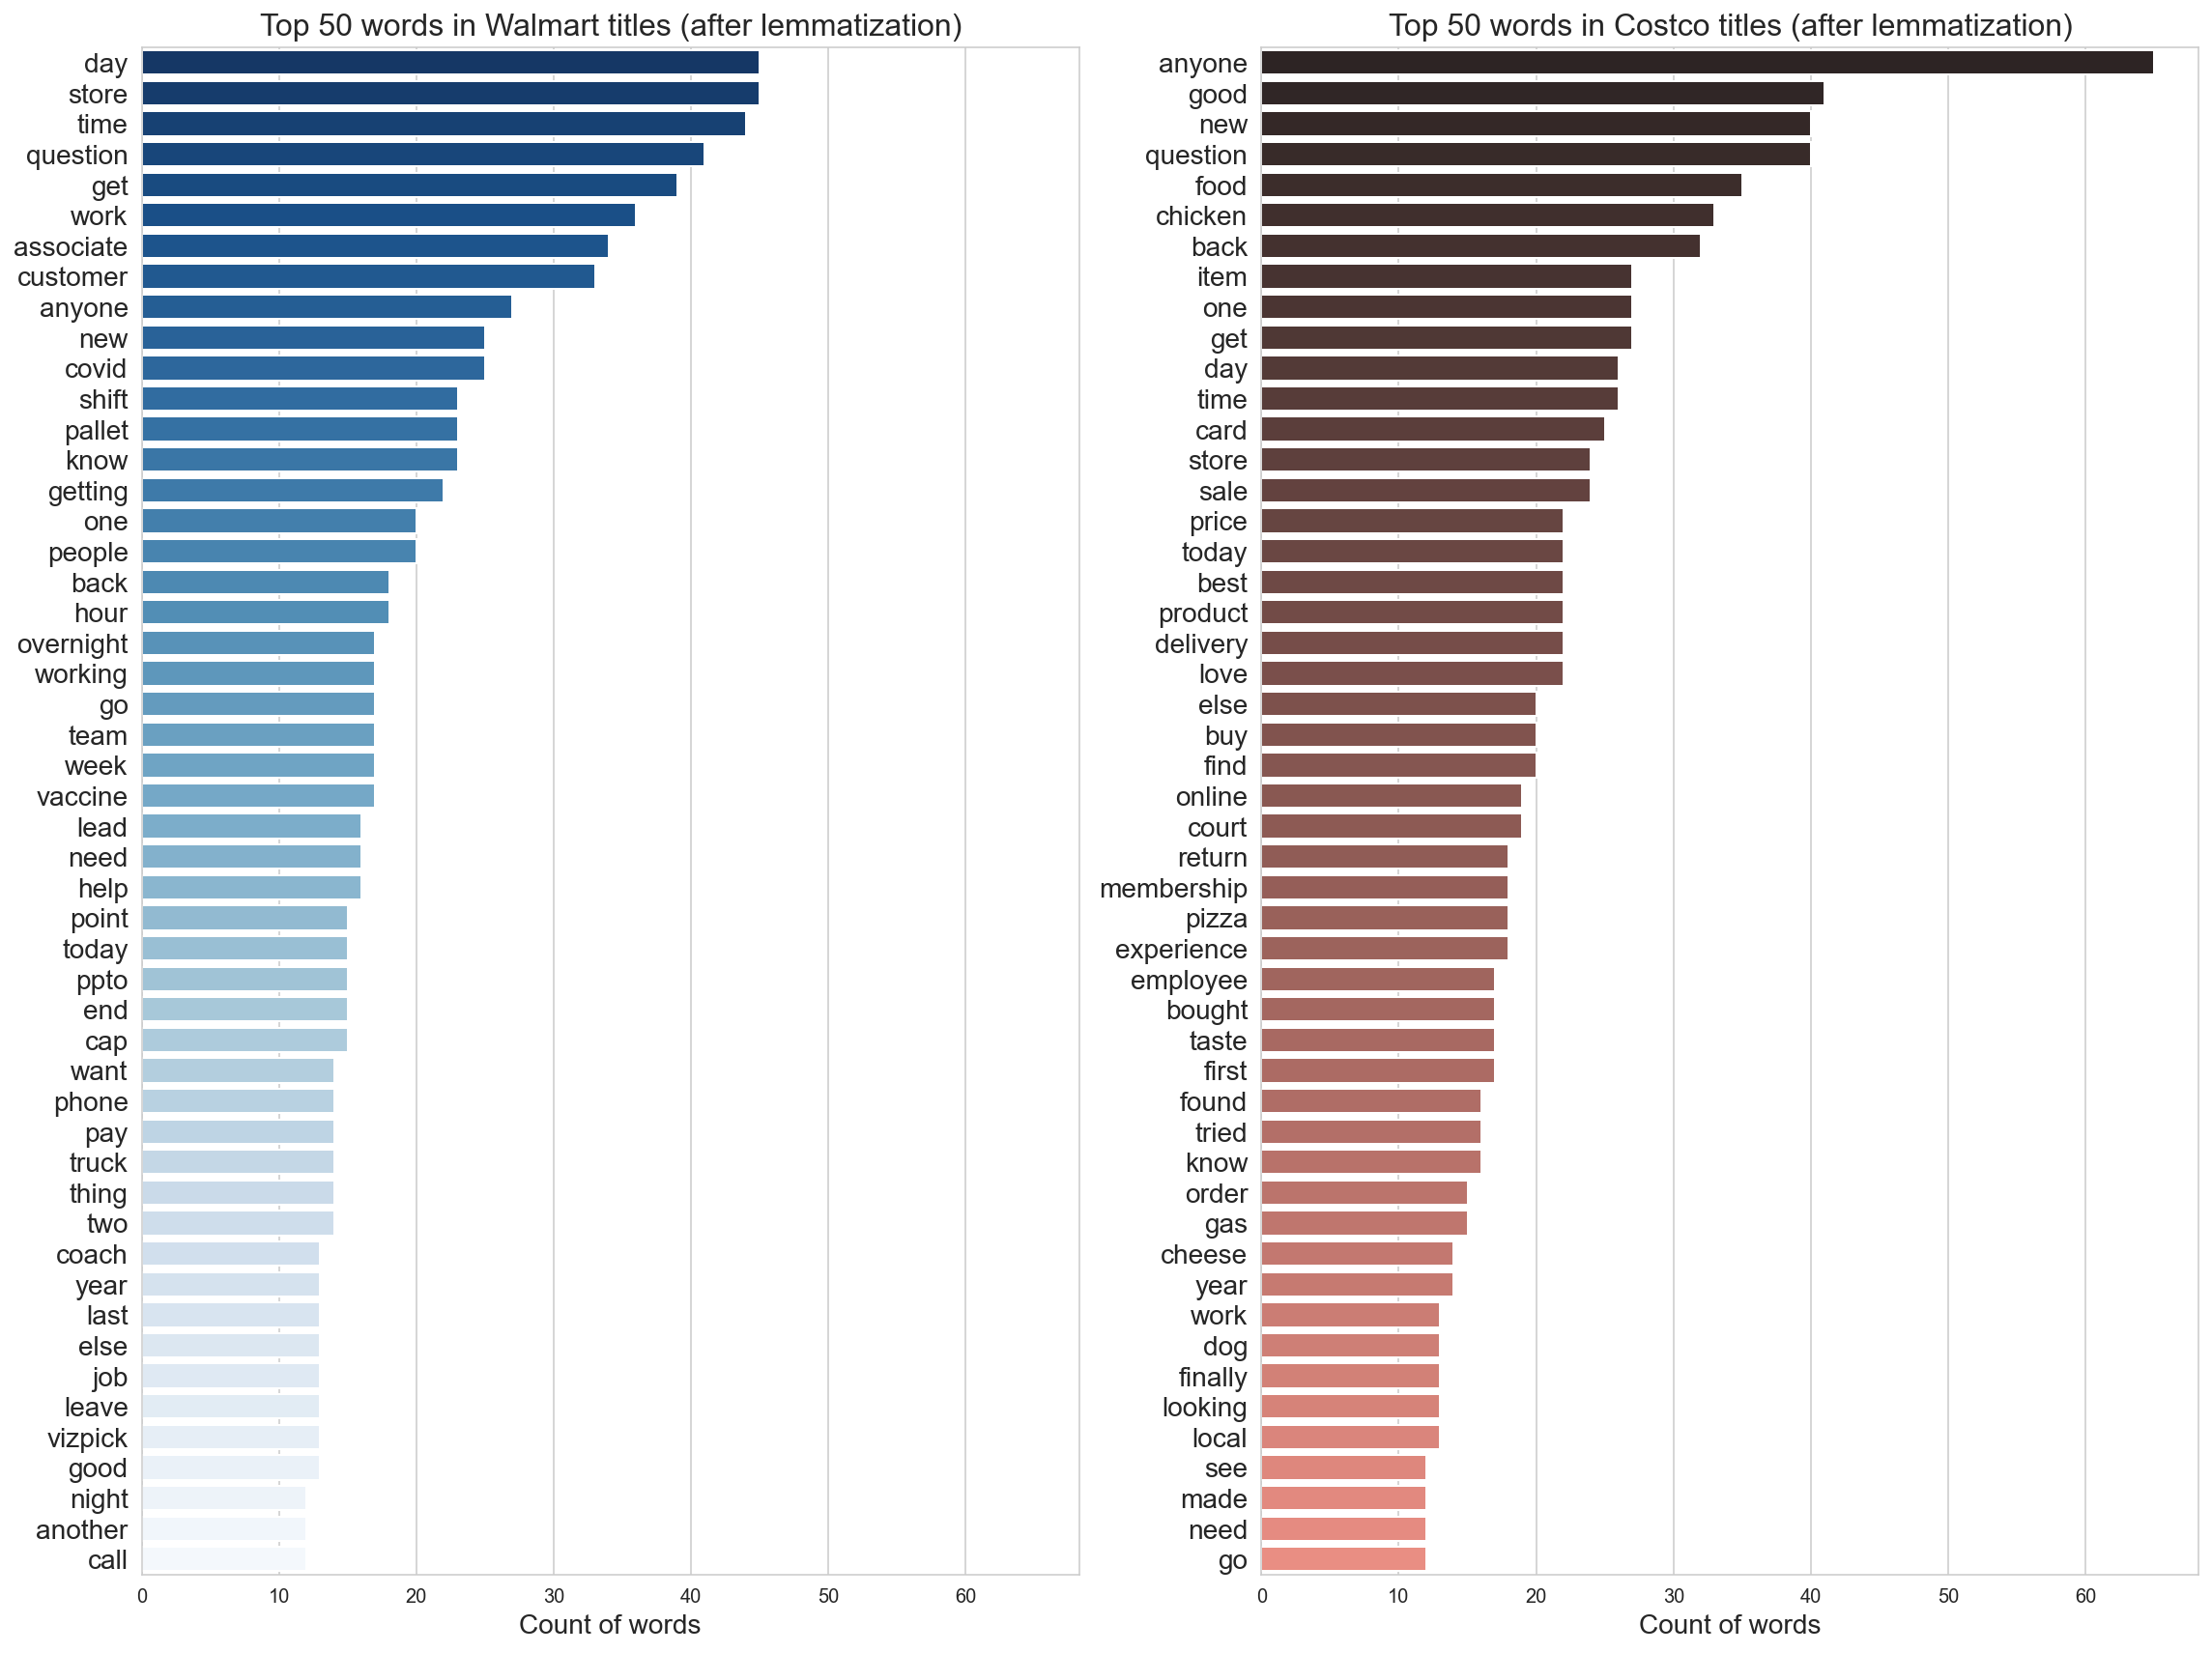

In [22]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,12), sharex=True)

# plot results for Walmart
sns.barplot(y=walmart_title_lem.index.values, x=walmart_title_lem, palette='Blues_r', ax=ax[0])
ax[0].set_title('Top 50 words in Walmart titles (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Costco
sns.barplot(y=costco_title_lem.index.values, x=costco_title_lem, palette='dark:salmon', ax=ax[1])
ax[1].set_title('Top 50 words in Costco titles (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

**Visualizaing most commonly occurring one-word in Walmart and Costco after lemmatization and addition of new stop words - using Word Cloud**

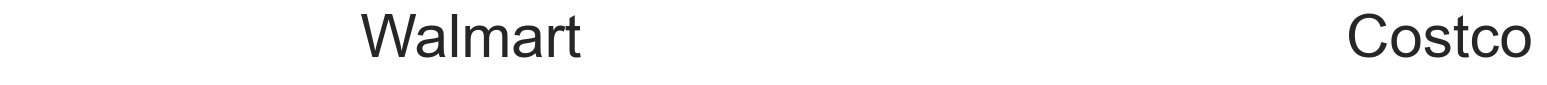

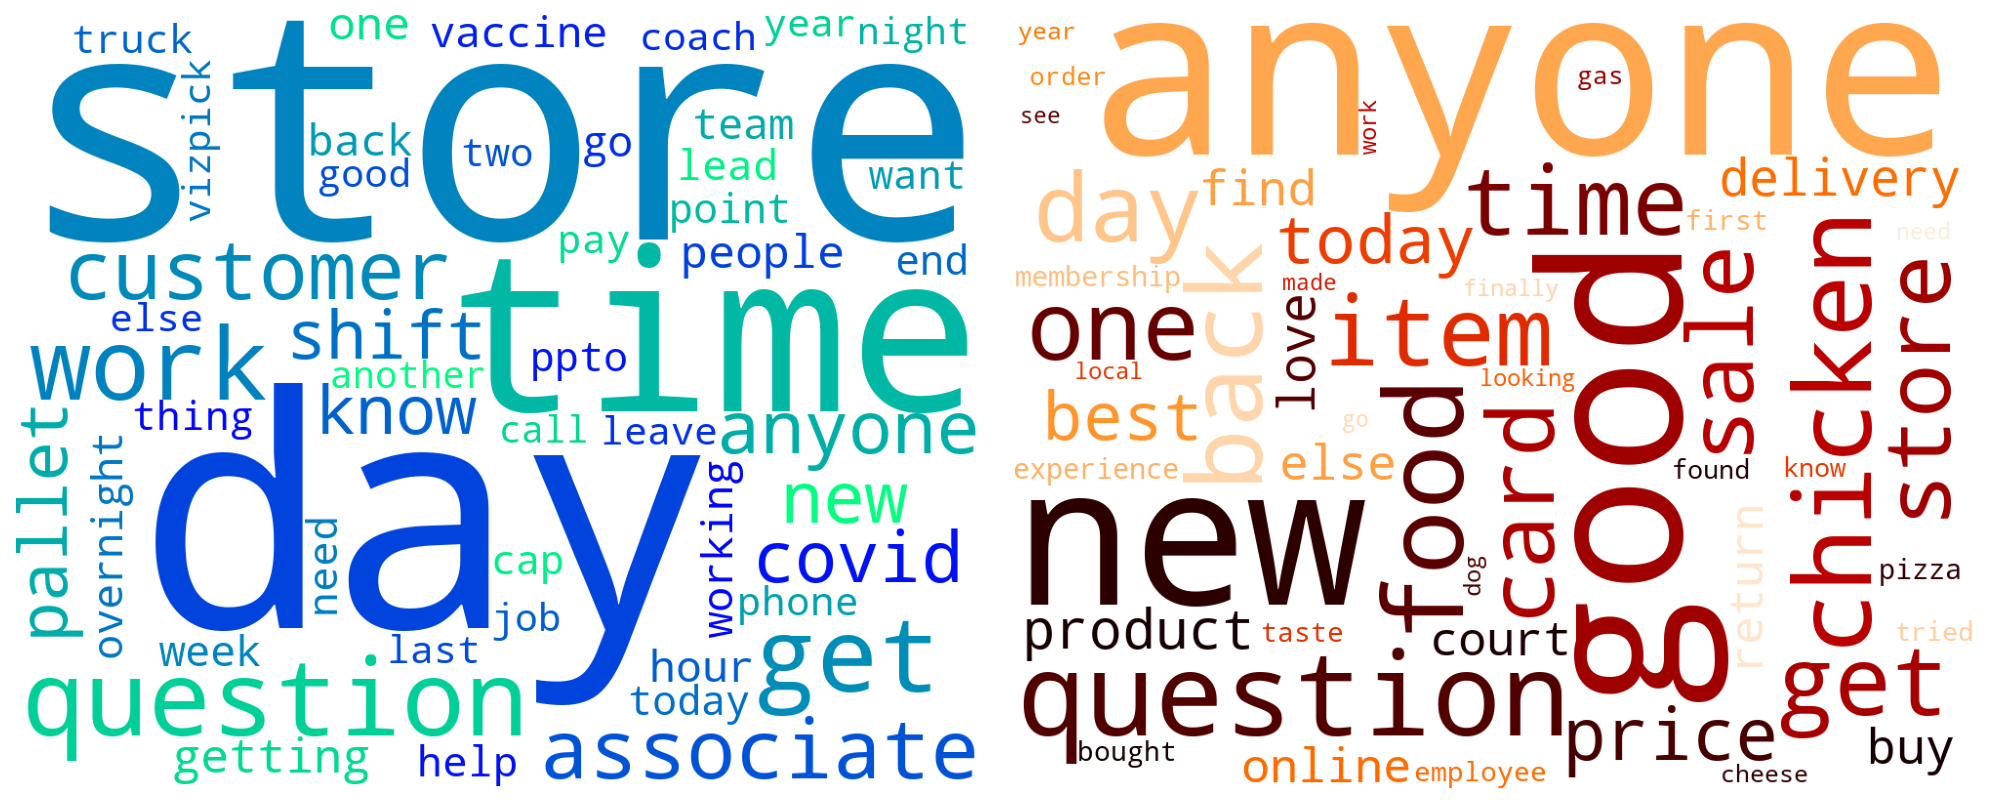

In [23]:
# set up WordCloud
wc_walmart = WordCloud(max_words=50, width=1000, height=800, background_color='white',
                       colormap='winter').generate_from_frequencies(walmart_title_lem) 

wc_costco = WordCloud(max_words=50, width=1000, height=800, background_color ='white',
                      colormap='gist_heat').generate_from_frequencies(costco_title_lem) 

plt.figure(figsize=(8,0.3))
plt.text(x=0.35,                              
         y=0.9,                             
         s='  Walmart                                              Costco', 
         ha='left',                        
         va='center',                       
         size=30)                         
plt.axis('off')

# plot the WordCloud image 
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].imshow(wc_walmart)
ax[0].axis('off')
ax[1].imshow(wc_costco)
ax[1].axis('off')
plt.tight_layout()

- After applying lemmatization and the addition of new stop words to the default set of stop words, we observe that the top words that commonly appear in the respective subreddits include: 
    - Walmart: 'day', 'store', 'time', 'associate', 'covid'
    - Costco: 'anyone', 'good', 'new', 'food', 'chicken' 

#### Exploring the most commonly occurring two-word phrases in Walmart and Costco after lemmatization and addition of new stop words

In [24]:
# instantiate CountVectorizer (two-word, with stop words removed)
cvec = CountVectorizer(ngram_range=(2,2), stop_words=model_stopwords)

# Walmart - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
walmart_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==0]['title_lemmatized'])
print('No. of features in Walmart after removing stop words: {}'.format(len(cvec.get_feature_names())))
walmart_cvec = pd.DataFrame(walmart_cvec.toarray(), 
                            columns = cvec.get_feature_names())
walmart_title_lem = walmart_cvec.sum().sort_values(ascending=False).head(50)

# Costco - fit/transform the CountVectorizer to the title and obtain the top 50 words with the highest count
costco_cvec = cvec.fit_transform(titles_df[titles_df['subreddit']==1]['title_lemmatized'])
print('No. of features in Costco after removing stop words: {}'.format(len(cvec.get_feature_names())))
costco_cvec = pd.DataFrame(costco_cvec.toarray(), 
                           columns = cvec.get_feature_names())
costco_title_lem = costco_cvec.sum().sort_values(ascending=False).head(50)

No. of features in Walmart after removing stop words: 2960
No. of features in Costco after removing stop words: 4117


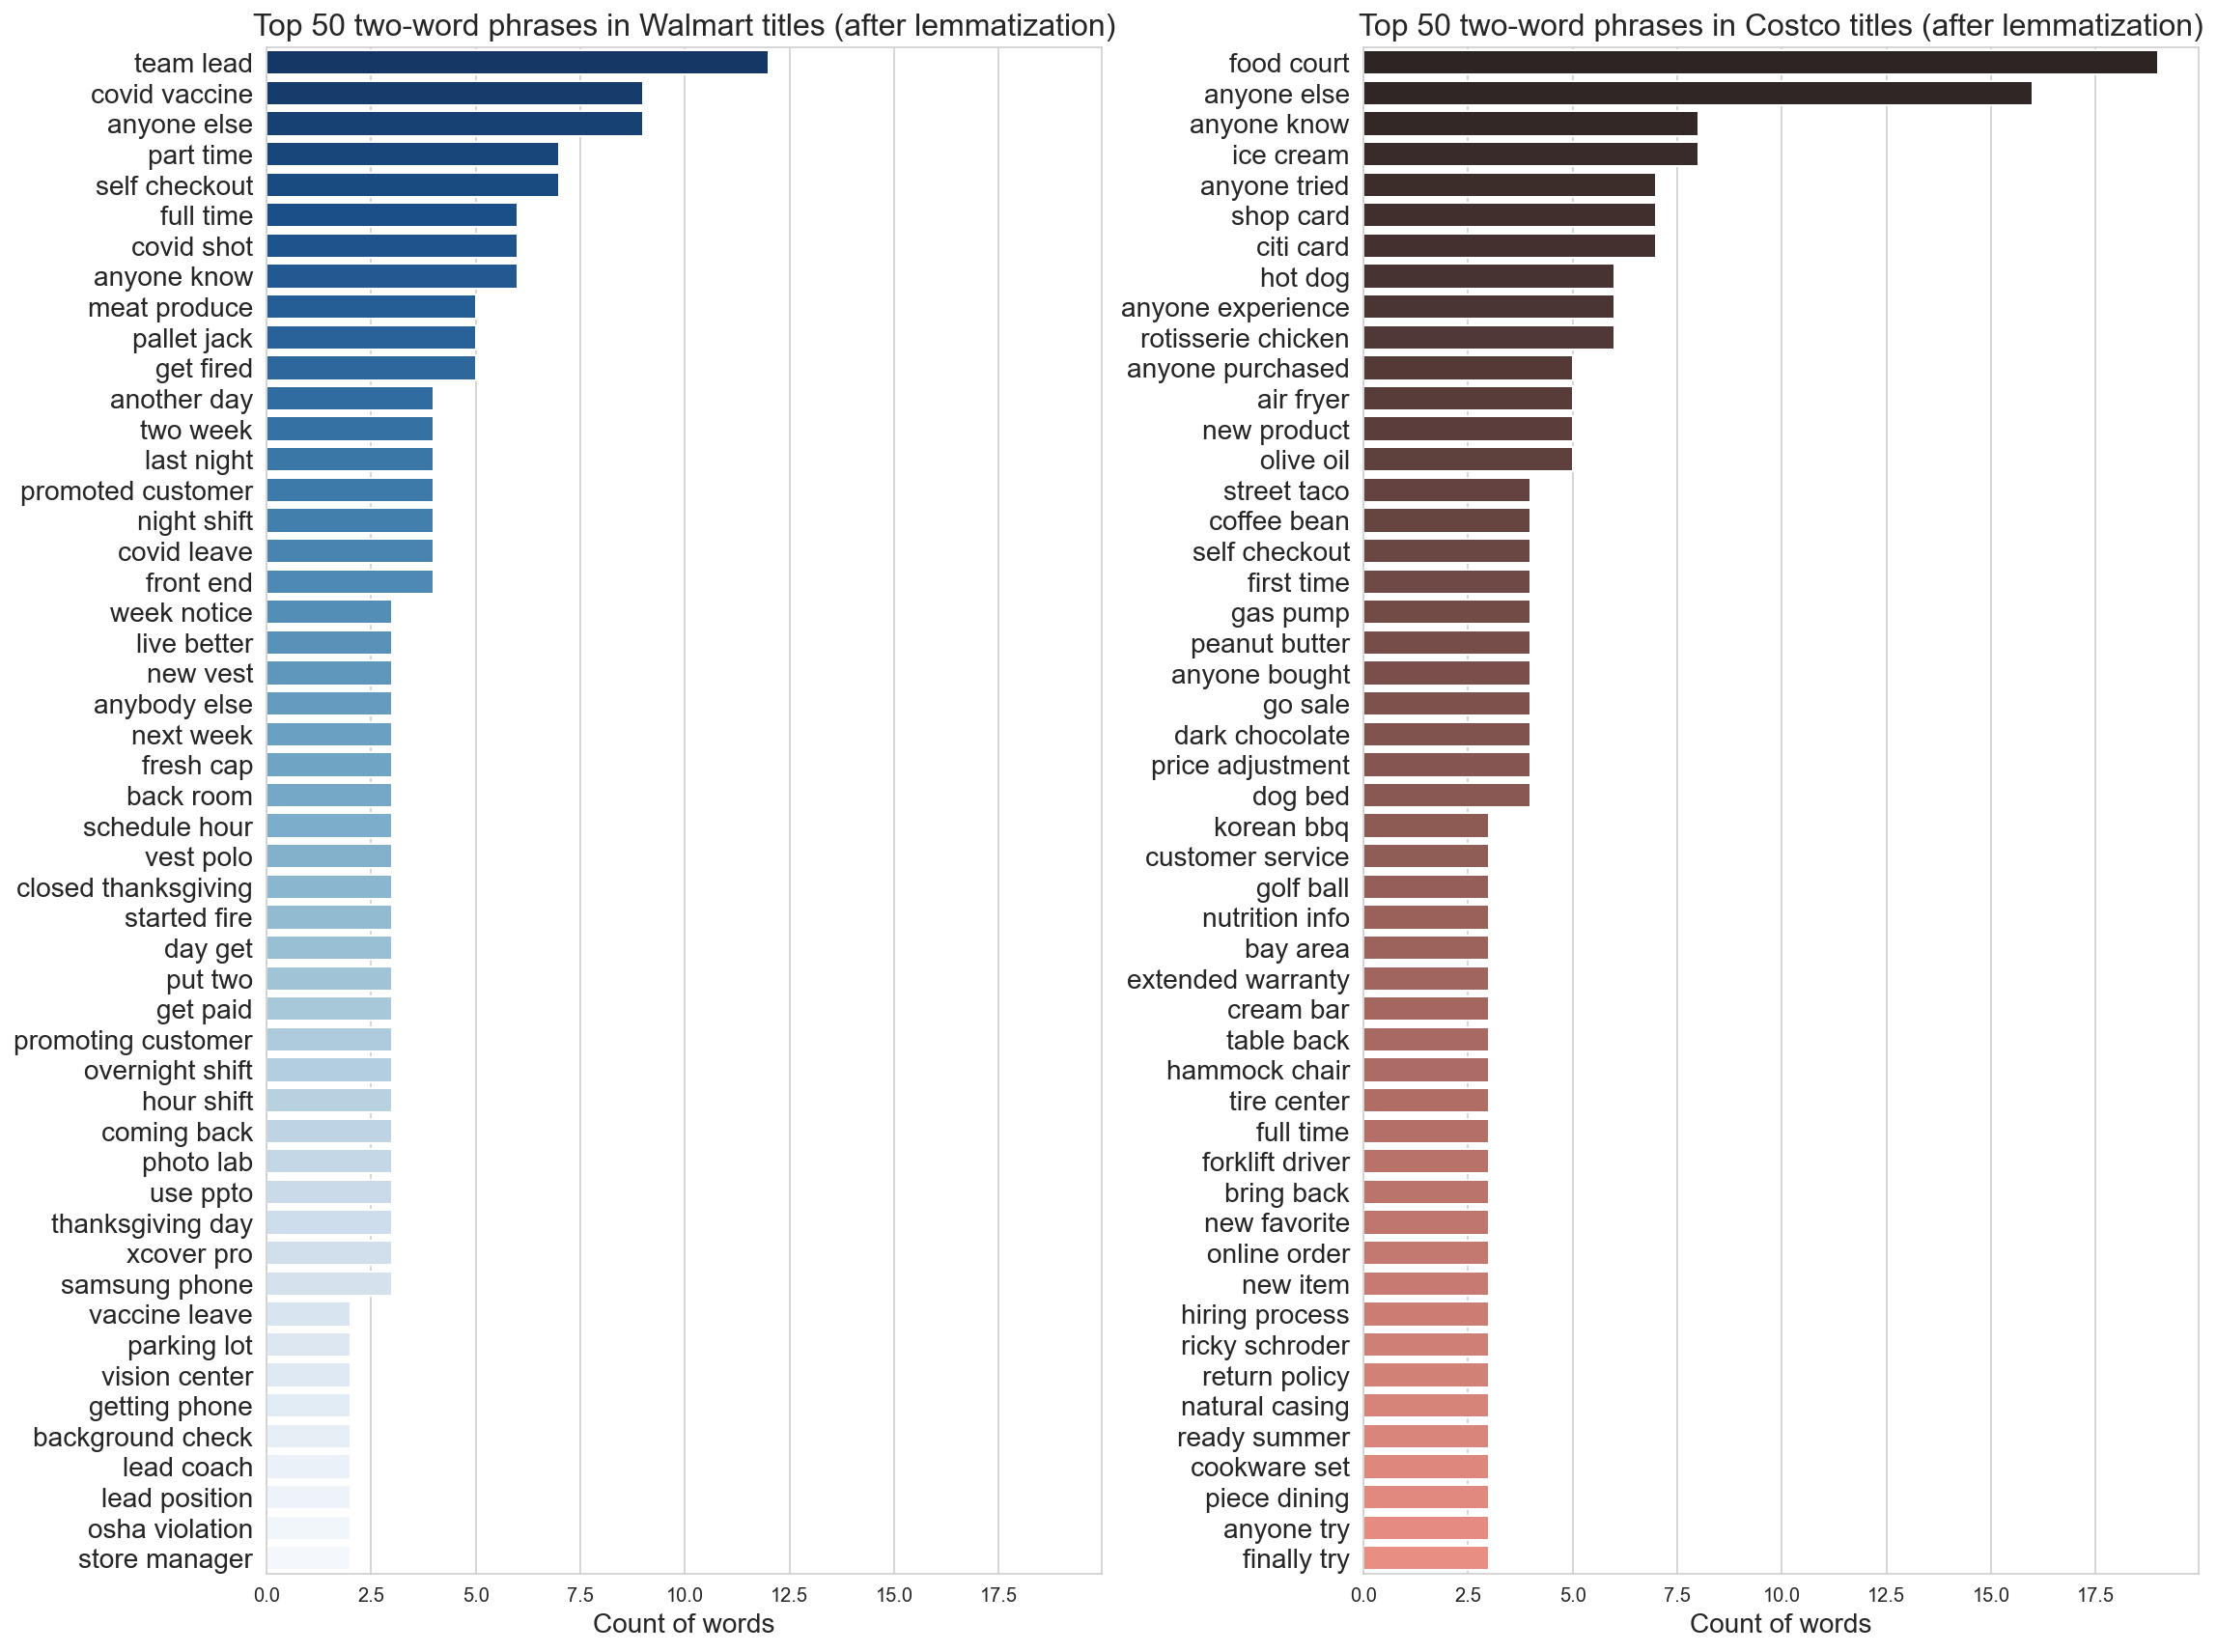

In [25]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,12), sharex=True)

# plot results for Walmart
sns.barplot(y=walmart_title_lem.index.values, x=walmart_title_lem, palette='Blues_r', ax=ax[0])
ax[0].set_title('Top 50 two-word phrases in Walmart titles (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Costco
sns.barplot(y=costco_title_lem.index.values, x=costco_title_lem, palette='dark:salmon', ax=ax[1])
ax[1].set_title('Top 50 two-word phrases in Costco titles (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

**Visualizing most commonly occurring two-word phrases in Walmart and Costco after lemmatization and addition of new stop words - using Word Cloud**

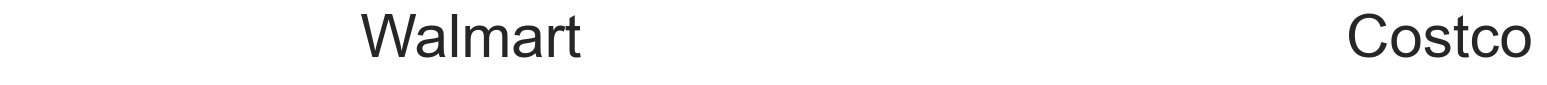

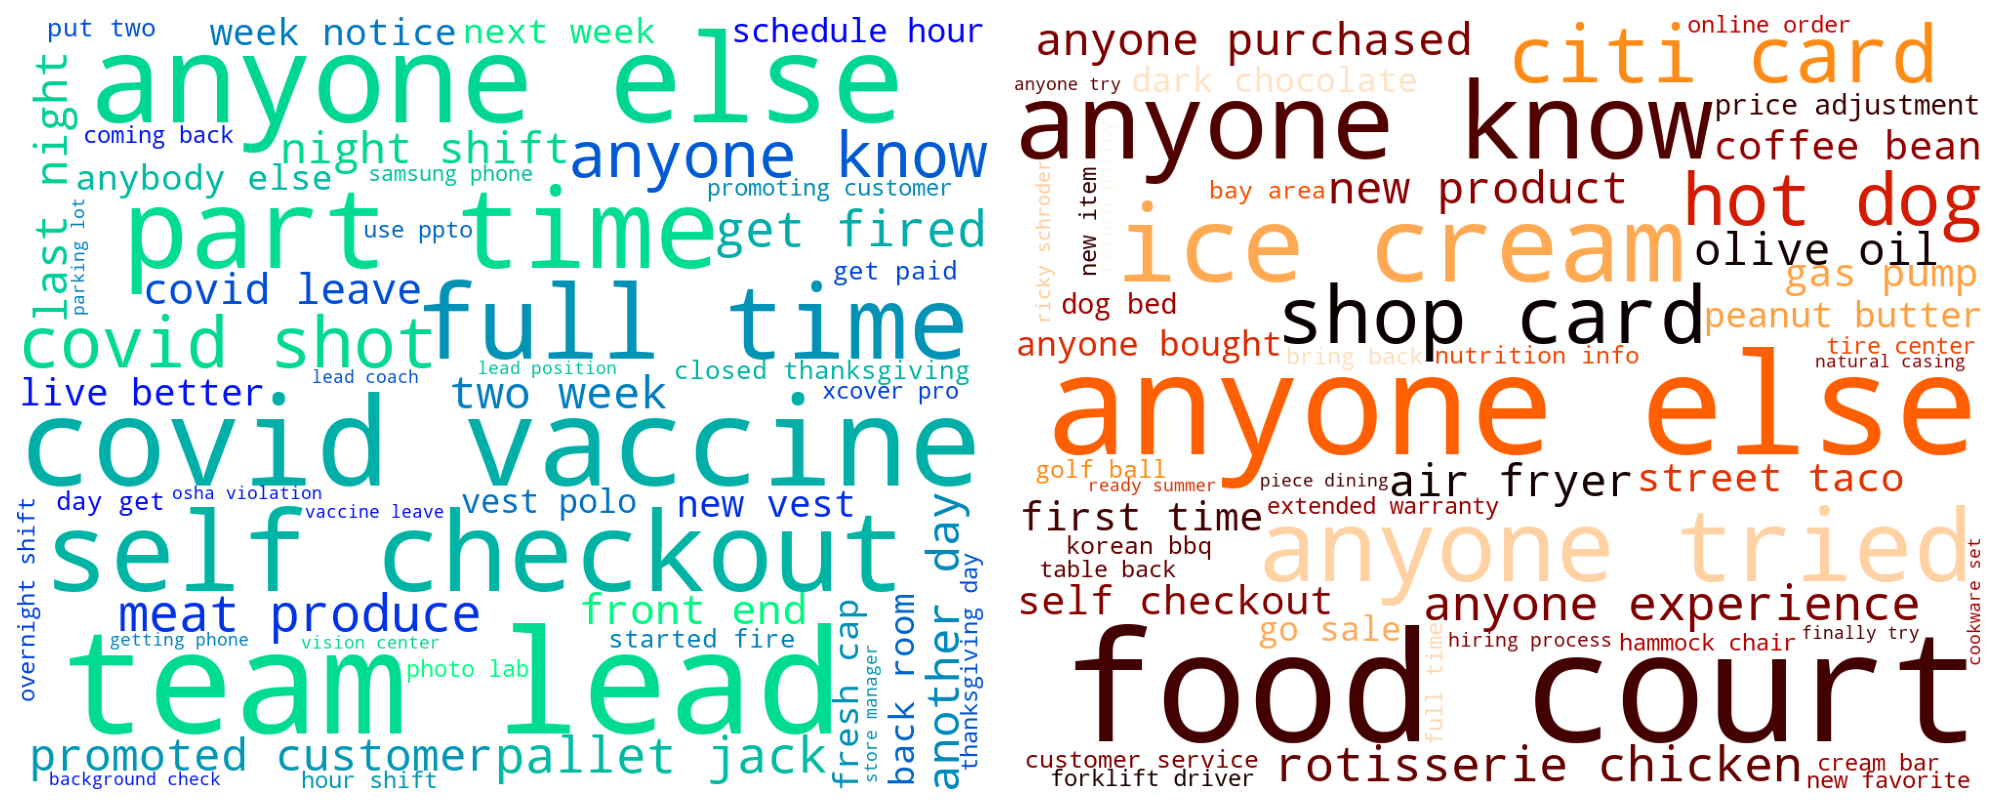

In [26]:
# set up WordCloud
wc_walmart = WordCloud(max_words=50, width=1000, height=800, background_color='white',
                       colormap='winter').generate_from_frequencies(walmart_title_lem) 

wc_costco = WordCloud(max_words=50, width=1000, height=800, background_color ='white',
                      colormap='gist_heat').generate_from_frequencies(costco_title_lem) 

plt.figure(figsize=(8,0.3))
plt.text(x=0.35,                              
         y=0.9,                             
         s='  Walmart                                              Costco', 
         ha='left',                        
         va='center',                       
         size=30)                         
plt.axis('off')

# plot the WordCloud image 
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].imshow(wc_walmart)
ax[0].axis('off')
ax[1].imshow(wc_costco)
ax[1].axis('off')
plt.tight_layout()

- After applying lemmatization and the addition of new stop words to the default set of stop words, we observe that the top two-word phrases that commonly appear in the respective subreddits include:
    - Walmart: 'covid vaccine', 'team lead', 'self checkout', 'part time', 'full time'
    - Costco: 'food court', 'ice cream', 'citi card', 'ice cream'


- We will proceed to export the DataFrame as a CSV file for storing, and for subsequent modelling.

In [27]:
# export the titles_df as a csv file
titles_df.to_csv('datasets/titles.csv')

### 5. Modelling

In this section, we will be using the following vectorizers and models to determine which combination of vectorizer and model performs the best in predicting whether a post belongs to Walmart or Costco. 
- Choice of `vectorizer`: 
     - Count Vectorizer
     - TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer
     
     
- Choice of `model`: 
     - Logistic Regression
     - Multinomial Naive Bayes
     - Random Forest Classifier
     - Support Vector Classifier


The default parameters in the vectorizers and models will be used, so as to provide a baseline on how the respective combinations will perform in the scenario where the best parameters are not utilized.

The combinations of vectorizer and models will be evaluated based on metrics such as accuracy score, recall score, precision score, F1 score, and ROC AUC score, in which the best model will be selected.

In [28]:
# create the X and y variables
X = titles_df['title_lemmatized']
y = titles_df['subreddit']

In [29]:
# create an empty list to store the results of the various combinations of vectorizers and models
scores_list = []

#### Combination #1: Count Vectorizer & Logistic Regression

In [30]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate CountVectorizer
cvec = CountVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
cvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

# create an empty results dictionary 
results_01 = {}

# instantiate Logistic Regression model 
lr = LogisticRegression()

# update the results list 
results_01['model'] = 'lr'
results_01['vectorizer'] = 'cvec'

# fit the training data
lr.fit(X_train, y_train)

# create predictions based on test data
preds = lr.predict(X_test)

# compare the score obtained from training and test data 
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
crossval_score = cross_val_score(lr, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_01['train_score'] = train_score
results_01['test_score'] = test_score
results_01['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_01['true_neg'] = tn
results_01['false_pos'] = fp
results_01['false_neg'] = fn
results_01['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_01['accuracy'] = accuracy
results_01['recall'] = recall
results_01['precision'] = precision
results_01['f1_score'] = f1score
results_01['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_01)

Training Score: 0.975885455915599
Test Score: 0.7842105263157895
Cross Validation Score: 0.7822244289970209


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 234                  44
Actual positive                  79                 213


Accuracy Score: 0.7842105263157895
Recall Score: 0.7294520547945206
Precision Score: 0.8287937743190662
F1-Score: 0.7759562841530054
ROC AUC Score: 0.8488900660293682




#### Combination #2: Count Vectorizer & Multinomial Naive Bayes

In [31]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate CountVectorizer
cvec = CountVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
cvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

# create an empty results dictionary 
results_02 = {}

# instantiate MultinomialNB model 
nb = MultinomialNB()

# update the results list 
results_02['model'] = 'nb'
results_02['vectorizer'] = 'cvec'

# fit the training data
nb.fit(X_train, y_train)

# create predictions based on test data
preds = nb.predict(X_test)

# compare the score obtained from training and test data 
train_score = nb.score(X_train, y_train)
test_score = nb.score(X_test, y_test)
crossval_score = cross_val_score(nb, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_02['train_score'] = train_score
results_02['test_score'] = test_score
results_02['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_02['true_neg'] = tn
results_02['false_pos'] = fp
results_02['false_neg'] = fn
results_02['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_02['accuracy'] = accuracy
results_02['recall'] = recall
results_02['precision'] = precision
results_02['f1_score'] = f1score
results_02['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_02)

Training Score: 0.9442351168048229
Test Score: 0.7807017543859649
Cross Validation Score: 0.7852376223577813


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 220                  58
Actual positive                  67                 225


Accuracy Score: 0.7807017543859649
Recall Score: 0.7705479452054794
Precision Score: 0.7950530035335689
F1-Score: 0.7826086956521738
ROC AUC Score: 0.8655513945008376




#### Combination #3: Count Vectorizer & Random Forest Classifier

In [32]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate CountVectorizer
cvec = CountVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
cvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

# create an empty results dictionary 
results_03 = {}

# instantiate RandomForestClassifier model 
rf = RandomForestClassifier()

# update the results list 
results_03['model'] = 'rf'
results_03['vectorizer'] = 'cvec'

# fit the training data
rf.fit(X_train, y_train)

# create predictions based on test data
preds = rf.predict(X_test)

# compare the score obtained from training and test data 
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
crossval_score = cross_val_score(rf, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_03['train_score'] = train_score
results_03['test_score'] = test_score
results_03['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_03['true_neg'] = tn
results_03['false_pos'] = fp
results_03['false_neg'] = fn
results_03['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_03['accuracy'] = accuracy
results_03['recall'] = recall
results_03['precision'] = precision
results_03['f1_score'] = f1score
results_03['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_03)

Training Score: 0.9984928409947249
Test Score: 0.7210526315789474
Cross Validation Score: 0.7241906653426018


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 245                  33
Actual positive                 126                 166


Accuracy Score: 0.7210526315789474
Recall Score: 0.5684931506849316
Precision Score: 0.8341708542713567
F1-Score: 0.6761710794297352
ROC AUC Score: 0.8087858480339015




#### Combination #4: Count Vectorizer & Support Vector Classifier

In [33]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate CountVectorizer
cvec = CountVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
cvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

# create an empty results dictionary 
results_04 = {}

# instantiate SVC model 
svc = SVC(probability=True)

# update the results list 
results_04['model'] = 'svc'
results_04['vectorizer'] = 'cvec'

# fit the training data
svc.fit(X_train, y_train)

# create predictions based on test data
preds = svc.predict(X_test)

# compare the score obtained from training and test data 
train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)
crossval_score = cross_val_score(svc, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_04['train_score'] = train_score
results_04['test_score'] = test_score
results_04['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_04['true_neg'] = tn
results_04['false_pos'] = fp
results_04['false_neg'] = fn
results_04['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_04['accuracy'] = accuracy
results_04['recall'] = recall
results_04['precision'] = precision
results_04['f1_score'] = f1score
results_04['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_04)

Training Score: 0.9570459683496609
Test Score: 0.7035087719298245
Cross Validation Score: 0.7309859554546744


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 232                  46
Actual positive                 123                 169


Accuracy Score: 0.7035087719298245
Recall Score: 0.5787671232876712
Precision Score: 0.786046511627907
F1-Score: 0.6666666666666666
ROC AUC Score: 0.7979760027594364




#### Combination #5: TF-IDF Vectorizer & Logistic Regression

In [34]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
tvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

# create an empty results dictionary 
results_05 = {}

# instantiate Logistic Regression model 
lr = LogisticRegression()

# update the results list 
results_05['model'] = 'lr'
results_05['vectorizer'] = 'tvec'

# fit the training data
lr.fit(X_train, y_train)

# create predictions based on test data
preds = lr.predict(X_test)

# compare the score obtained from training and test data 
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
crossval_score = cross_val_score(lr, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_05['train_score'] = train_score
results_05['test_score'] = test_score
results_05['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_05['true_neg'] = tn
results_05['false_pos'] = fp
results_05['false_neg'] = fn
results_05['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_05['accuracy'] = accuracy
results_05['recall'] = recall
results_05['precision'] = precision
results_05['f1_score'] = f1score
results_05['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_05)

Training Score: 0.9540316503391107
Test Score: 0.7807017543859649
Cross Validation Score: 0.7581132075471698


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 207                  71
Actual positive                  54                 238


Accuracy Score: 0.7807017543859649
Recall Score: 0.815068493150685
Precision Score: 0.7702265372168284
F1-Score: 0.7920133111480865
ROC AUC Score: 0.8496907953089584




#### Combination #6: TF-IDF Vectorizer & Multinomial Naive Bayes

In [35]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
tvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

# create an empty results dictionary 
results_06 = {}

# instantiate MultinomialNB model 
nb = MultinomialNB()

# update the results list 
results_06['model'] = 'nb'
results_06['vectorizer'] = 'tvec'

# fit the training data
nb.fit(X_train, y_train)

# create predictions based on test data
preds = nb.predict(X_test)

# compare the score obtained from training and test data 
train_score = nb.score(X_train, y_train)
test_score = nb.score(X_test, y_test)
crossval_score = cross_val_score(nb, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_06['train_score'] = train_score
results_06['test_score'] = test_score
results_06['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_06['true_neg'] = tn
results_06['false_pos'] = fp
results_06['false_neg'] = fn
results_06['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_06['accuracy'] = accuracy
results_06['recall'] = recall
results_06['precision'] = precision
results_06['f1_score'] = f1score
results_06['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_06)

Training Score: 0.9555388093443858
Test Score: 0.7929824561403509
Cross Validation Score: 0.784494254504185


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 220                  58
Actual positive                  60                 232


Accuracy Score: 0.7929824561403509
Recall Score: 0.7945205479452054
Precision Score: 0.8
F1-Score: 0.7972508591065294
ROC AUC Score: 0.8706699024342169




#### Combination #7: TF-IDF Vectorizer & Random Forest Classifier

In [36]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
tvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

# create an empty results dictionary 
results_07 = {}

# instantiate RandomForestClassifier model 
rf = RandomForestClassifier()

# update the results list 
results_07['model'] = 'rf'
results_07['vectorizer'] = 'tvec'

# fit the training data
rf.fit(X_train, y_train)

# create predictions based on test data
preds = rf.predict(X_test)

# compare the score obtained from training and test data 
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
crossval_score = cross_val_score(rf, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_07['train_score'] = train_score
results_07['test_score'] = test_score
results_07['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_07['true_neg'] = tn
results_07['false_pos'] = fp
results_07['false_neg'] = fn
results_07['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_07['accuracy'] = accuracy
results_07['recall'] = recall
results_07['precision'] = precision
results_07['f1_score'] = f1score
results_07['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_07)

Training Score: 0.9984928409947249
Test Score: 0.7052631578947368
Cross Validation Score: 0.7060888069229677


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 245                  33
Actual positive                 135                 157


Accuracy Score: 0.7052631578947368
Recall Score: 0.5376712328767124
Precision Score: 0.8263157894736842
F1-Score: 0.6514522821576765
ROC AUC Score: 0.8010372523898688




#### Combination #8: TF-IDF Vectorizer & Support Vector Classifier

In [37]:
# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words=model_stopwords)

# fit the vectorizer on training data
tvec.fit(X_train)

# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

# create an empty results dictionary 
results_08 = {}

# instantiate SVC model 
svc = SVC(probability=True)

# update the results list 
results_08['model'] = 'svc'
results_08['vectorizer'] = 'tvec'

# fit the training data
svc.fit(X_train, y_train)

# create predictions based on test data
preds = svc.predict(X_test)

# compare the score obtained from training and test data 
train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)
crossval_score = cross_val_score(svc, X_train, y_train, cv=5).mean()

print('Training Score: {}'.format(train_score))
print('Test Score: {}'.format(test_score))
print('Cross Validation Score: {}'.format(crossval_score))
print('\n')

# update the results list with train, test, cv scores
results_08['train_score'] = train_score
results_08['test_score'] = test_score
results_08['cv_score'] = crossval_score

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, preds),
                   index=['Actual negative', 'Actual positive'], 
                   columns=['Predicted negative', 'Predicted positive']))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# update confusion metric results onto results list
results_08['true_neg'] = tn
results_08['false_pos'] = fp
results_08['false_neg'] = fn
results_08['true_pos'] = tp
print('\n')

# obtain the various metrics
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)
rocauc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

print('Accuracy Score: {}'.format(accuracy))
print('Recall Score: {}'.format(recall))
print('Precision Score: {}'.format(precision))
print('F1-Score: {}'.format(f1score))
print('ROC AUC Score: {}'.format(rocauc))

# update various metrics onto results list
results_08['accuracy'] = accuracy
results_08['recall'] = recall
results_08['precision'] = precision
results_08['f1_score'] = f1score
results_08['roc_auc'] = rocauc
print('\n')

# append results to scores_list
scores_list.append(results_08)

Training Score: 0.9924642049736248
Test Score: 0.7842105263157895
Cross Validation Score: 0.7618839551709463


Confusion matrix:
                 Predicted negative  Predicted positive
Actual negative                 219                  59
Actual positive                  64                 228


Accuracy Score: 0.7842105263157895
Recall Score: 0.7808219178082192
Precision Score: 0.794425087108014
F1-Score: 0.7875647668393783
ROC AUC Score: 0.835868976052035




In [38]:
# convert the scores_list into a dataframe
scores_df = pd.DataFrame(scores_list)

# view the results of all 8 combinations 
scores_df

,model,vectorizer,train_score,test_score,cv_score,true_neg,false_pos,false_neg,true_pos,accuracy,recall,precision,f1_score,roc_auc
0,lr,cvec,0.975885,0.784211,0.782224,234,44,79,213,0.784211,0.729452,0.828794,0.775956,0.848890
1,nb,cvec,0.944235,0.780702,0.785238,220,58,67,225,0.780702,0.770548,0.795053,0.782609,0.865551
2,rf,cvec,0.998493,0.721053,0.724191,245,33,126,166,0.721053,0.568493,0.834171,0.676171,0.808786
3,svc,cvec,0.957046,0.703509,0.730986,232,46,123,169,0.703509,0.578767,0.786047,0.666667,0.797976
4,lr,tvec,0.954032,0.780702,0.758113,207,71,54,238,0.780702,0.815068,0.770227,0.792013,0.849691
5,nb,tvec,0.955539,0.792982,0.784494,220,58,60,232,0.792982,0.794521,0.800000,0.797251,0.870670
6,rf,tvec,0.998493,0.705263,0.706089,245,33,135,157,0.705263,0.537671,0.826316,0.651452,0.801037
7,svc,tvec,0.992464,0.784211,0.761884,219,59,64,228,0.784211,0.780822,0.794425,0.787565,0.835869


In [39]:
# create a new column to store the difference between training score and test score
scores_df['diff_in_train_test'] = scores_df['train_score'] - scores_df['test_score']

# view the new column 
scores_df

,model,vectorizer,train_score,test_score,cv_score,true_neg,false_pos,false_neg,true_pos,accuracy,recall,precision,f1_score,roc_auc,diff_in_train_test
0,lr,cvec,0.975885,0.784211,0.782224,234,44,79,213,0.784211,0.729452,0.828794,0.775956,0.848890,0.191675
1,nb,cvec,0.944235,0.780702,0.785238,220,58,67,225,0.780702,0.770548,0.795053,0.782609,0.865551,0.163533
2,rf,cvec,0.998493,0.721053,0.724191,245,33,126,166,0.721053,0.568493,0.834171,0.676171,0.808786,0.277440
3,svc,cvec,0.957046,0.703509,0.730986,232,46,123,169,0.703509,0.578767,0.786047,0.666667,0.797976,0.253537
4,lr,tvec,0.954032,0.780702,0.758113,207,71,54,238,0.780702,0.815068,0.770227,0.792013,0.849691,0.173330
5,nb,tvec,0.955539,0.792982,0.784494,220,58,60,232,0.792982,0.794521,0.800000,0.797251,0.870670,0.162556
6,rf,tvec,0.998493,0.705263,0.706089,245,33,135,157,0.705263,0.537671,0.826316,0.651452,0.801037,0.293230
7,svc,tvec,0.992464,0.784211,0.761884,219,59,64,228,0.784211,0.780822,0.794425,0.787565,0.835869,0.208254


### 6. Evaluation of Model & Vectorizer Performance

For this section, we will evaluate the performances of the combinations of models and vectorizers using metrics such as accuracy score, recall score, precision score, F1 score, and ROC AUC score. Earlier, we have derived a baseline accuracy of **51.2%** for our classification model to predict whether a post belongs to Walmart (subreddit = 0) or Costco (subreddit = 1). 


**Using Accuracy as a metric**
- We observe that all the models perform better than the baseline model (score). 
- Particularly, **Random Forest Classifier and TF-IDF Vectorizer** provides the highest accuracy score of 99.8% on training data set, whereas **Multinomial Naive Bayes and TF-IDF Vectorizer** gives the highest accuracy score of 79.3% on test data set.
- While most of the combinations of vectorizers and models indicate overfitting of the models (i.e. score on training data set is higher than that of test data set), the following combinations provide the least variance between the train and test scores: 
    1. **Multinomial Naive Bayes and TF-IDF Vectorizer** - 16.3%
    2. **Multinomial Naive Bayes and Count Vectorizer** - 16.4%
    3. **Logistic Regression and TF-IDF Vectorizer** - 17.3%
    

**Using Recall (Sensitivity) as a metric**
- We observe that **Logistic Regression and TF-IDF Vectorizer** provides the highest recall (sensitivity) score of 81.5%, followed by **Multinomial Naive Bayes and TF-IDF Vectorizer** with a score of 79.5%, which essentially looks at how many Costco posts (actual positive) are predicted correctly to be Costco posts.


**Using Precision as a metric**
- We observe that **Random Forest Classifier and Count Vectorizer** provides the highest precision score of 84.0%, followed by **Random Forest Classifier and TF-IDF Vectorizer** with a score of 83.8%, which essentially looks at how many posts that have been predicted to belong to Costco, are indeed correct.


**Using F1-Score as a metric**
- We observe that **Multinomial Naive Bayes and TF-IDF Vectorizer** provides the highest F1-score of 79.7%, followed by **Logistic Regression and TF-IDF Vectorizer** with a score of 79.2%, which essentially looks at a balance between recall and precision scores. 


**Using ROC AUC Score as a metric**
- We observe that **Multinomial Naive Bayes and TF-IDF Vectorizer** provides the highest ROC AUC score of 87.1%, followed by **Multinomial Naive Bayes and Count Vectorizer** with a score of 86.6% and **Logistic Regression and TF-IDF Vectorizer**  with a score of 85.0%, which essentially looks at how separated are the posts between Walmart and Costco. 


**Selection of Vectorizer & Model**
- Based on the above metrics, it seems that the combinations of **Multinomial Naive Bayes and TF-IDF Vectorizer**, as well as **Logistic Regression and TF-IDF Vectorizer**, are the top choices. 
- We will select the combination of **Logistic Regression and TF-IDF Vectorizer** as the model for this project, because: 
    1. Logistic Regression can interpret the model coefficients as indicators of feature importance, and when coupled with the Sentiment Analysis, it allows us to understand the rationale behind the occurrence of the top words.    
    2. Logistic Regression can indicate the direction of the association (i.e. positive or negative) based on the coefficient values, i.e. positive values referring to words for Costco, and negative values referring to words for Walmart. 
    3. TF-IDF Vectorizer takes into consideration the frequency of the words in a sentence, when assessing their importance. 
- It should however be noted that one major limitation of Logistic Regression is that it assumes that the dependent variable (in this case whether the words belong to Walmart or Costco subreddits) and independent variables (individual words) are linearly related, which may not necessarily hold true. 

### 7. Creating Predictions with the Selected Model & Vectorizer 

In this section, we will apply the selected combination of **Logistic Regression and TF-IDF Vectorizer** on the test data set.
- For TF-IDF Vectorizer, we will instantiate it together with the most recently updated stop words, and default n-gram parameter of just one word. 
- For Logistic Regression, we will utilize GridSearchCV to identify the best parameters - i.e. whether it should be subjected to a lasso regularization (l1) or ridge regularization (l2) penalty, and identifying the regularization strength.

In [40]:
# create the X and y variables
X = titles_df['title_lemmatized']
y = titles_df['subreddit']

# create a train_test_split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [41]:
# instantiate TfidfVectorizer with updated stopwords
tvec = TfidfVectorizer(stop_words=model_stopwords)

# fit the training dataset
tvec.fit(X_train)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [42]:
# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

In [43]:
# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

In [44]:
# instantiate logistic regression 
lr = LogisticRegression()

# list out the parameters
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

# do a gridsearch for the best params for model 
lr_gridsearch = GridSearchCV(
            lr,
            lr_params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

lr_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 344 tasks      | elapsed:   27.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:   31.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 1.26638017e-04, 1.60371874e-04, 2.03091762e-04,
       2.57191381e-04, 3.25702066e-04, 4.12462638e-04, 5.22334507e-04,
       6.61474064e-04, 8.37677640e-04, 1.06081836e-03, 1.34339933e-03,
       1.70125428e-03, 2.15443469e-03, 2.72833338e-03, 3.45510729e-03,
       4.37547938e-03, 5.54102033e-03...8.88623816e-03,
       1.12533558e-02, 1.42510267e-02, 1.80472177e-02, 2.28546386e-02,
       2.89426612e-02, 3.66524124e-02, 4.64158883e-02, 5.87801607e-02,
       7.44380301e-02, 9.42668455e-02, 1.19377664e-01, 1.51177507e-01,
       1.91448198e-01, 2.42446202e-01, 3.07029063e-01, 3.88815518e-01,
       4.92388263e-01, 6.23550734e-01, 7.89652287e-01, 1.00000000e+00]),
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [45]:
# view the best parameters and scores following the GridSearchCV
print('Best parameters: {}'.format(lr_gridsearch.best_params_))
print('Best score: {}'.format(lr_gridsearch.best_score_))

Best parameters: {'C': 1.0, 'penalty': 'l2'}
Best score: 0.7581132075471698


- With the hypertuning of parameters via GridSearchCV, we observe that the best parameters include applying ridge regularization (l2), as well as the default C value (inverse of regularization strength) of 1.0. 
- The best score remained at 75.8%, despite utilizing GridSearchCV to obtain the best parameters for Logistic Regression.
- However, we will still proceed to generate predicions using this model.

In [46]:
# generate predictions
preds = lr_gridsearch.best_estimator_.predict(X_test)

In [47]:
# save the confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# print the tn, fp, fn, tp values
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

True Negatives: 207
False Positives: 71
False Negatives: 54
True Positives: 238


Accuracy Score: 0.7807017543859649
Recall Score: 0.815068493150685
Precision Score: 0.7702265372168284
F1-Score: 0.7920133111480865
ROC AUC Score: 0.8496907953089584


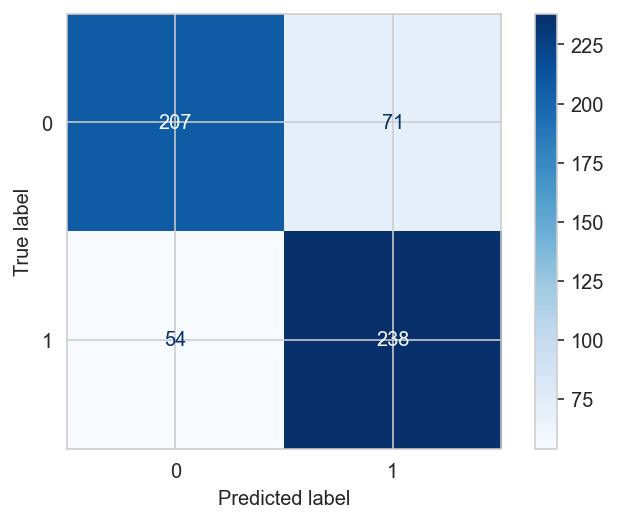

In [48]:
# view the confusion matrix
plot_confusion_matrix(lr_gridsearch.best_estimator_, X_test, y_test, cmap='Blues', values_format='d');

# print accuracy_score
print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
print('Recall Score: {}'.format(recall_score(y_test, preds)))
print('Precision Score: {}'.format(precision_score(y_test, preds)))
print('F1-Score: {}'.format(f1_score(y_test, preds)))
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, lr_gridsearch.predict_proba(X_test)[:,1])))

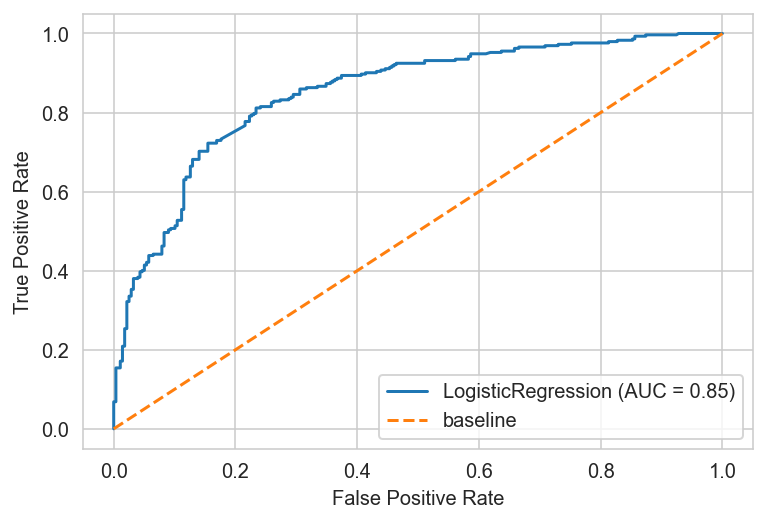

In [49]:
# plot the ROC curve
plot_roc_curve(lr_gridsearch.best_estimator_, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1],
         label = 'baseline',
         linestyle = '--')

# add a legend
plt.legend()

- As a summary, the combination of Logistic Regression and TF-IDF Vectorizer has allowed us to achieve: 
    - Accuracy score of 78.1%
    - Recall score of 81.5%
    - Precision score of 77.0%
    - F1-score of 79.2%
    - ROC AUC score of 85.0%


- Its accuracy score is around 26.9% higher than the baseline score, thus it can be utilized further to identify the top 20 words to determine whether a post belongs to Walmart or Costco. 

In [50]:
# create a DataFrame containing the features and their coefficients
coefficient_df = pd.DataFrame({'feature':X_test.columns, 'coef':lr_gridsearch.best_estimator_.coef_[0]})

# sort the values by their coefficients 
coefficient_df.sort_values(by=['coef'], inplace=True, ascending=False)  

In [51]:
# view the top 10 words that indicate that the posts will be considered as 'Costco'
print('Top 10 words for Costco')
coefficient_df.head(10)

Top 10 words for Costco


,feature,coef
389,chicken,1.877000
1334,membership,1.547481
842,food,1.429028
1610,pizza,1.402917
202,best,1.359575
584,delivery,1.356260
933,good,1.285356
1493,online,1.226899
78,anyone,1.223304
749,experience,1.164678


In [52]:
# view the top 10 words that indicate that the posts will be considered as 'Walmart'
print('Top 10 words for Walmart')
coefficient_df.tail(10)

Top 10 words for Walmart


,feature,coef
1235,loa,-1.152234
2418,vaccine,-1.162795
1245,lol,-1.202070
511,covid,-1.247384
1655,ppto,-1.313617
909,getting,-1.330085
1545,pallet,-1.339037
2145,store,-1.370500
119,associate,-1.498822
543,customer,-1.762374


Text(0, 0.5, 'Words')

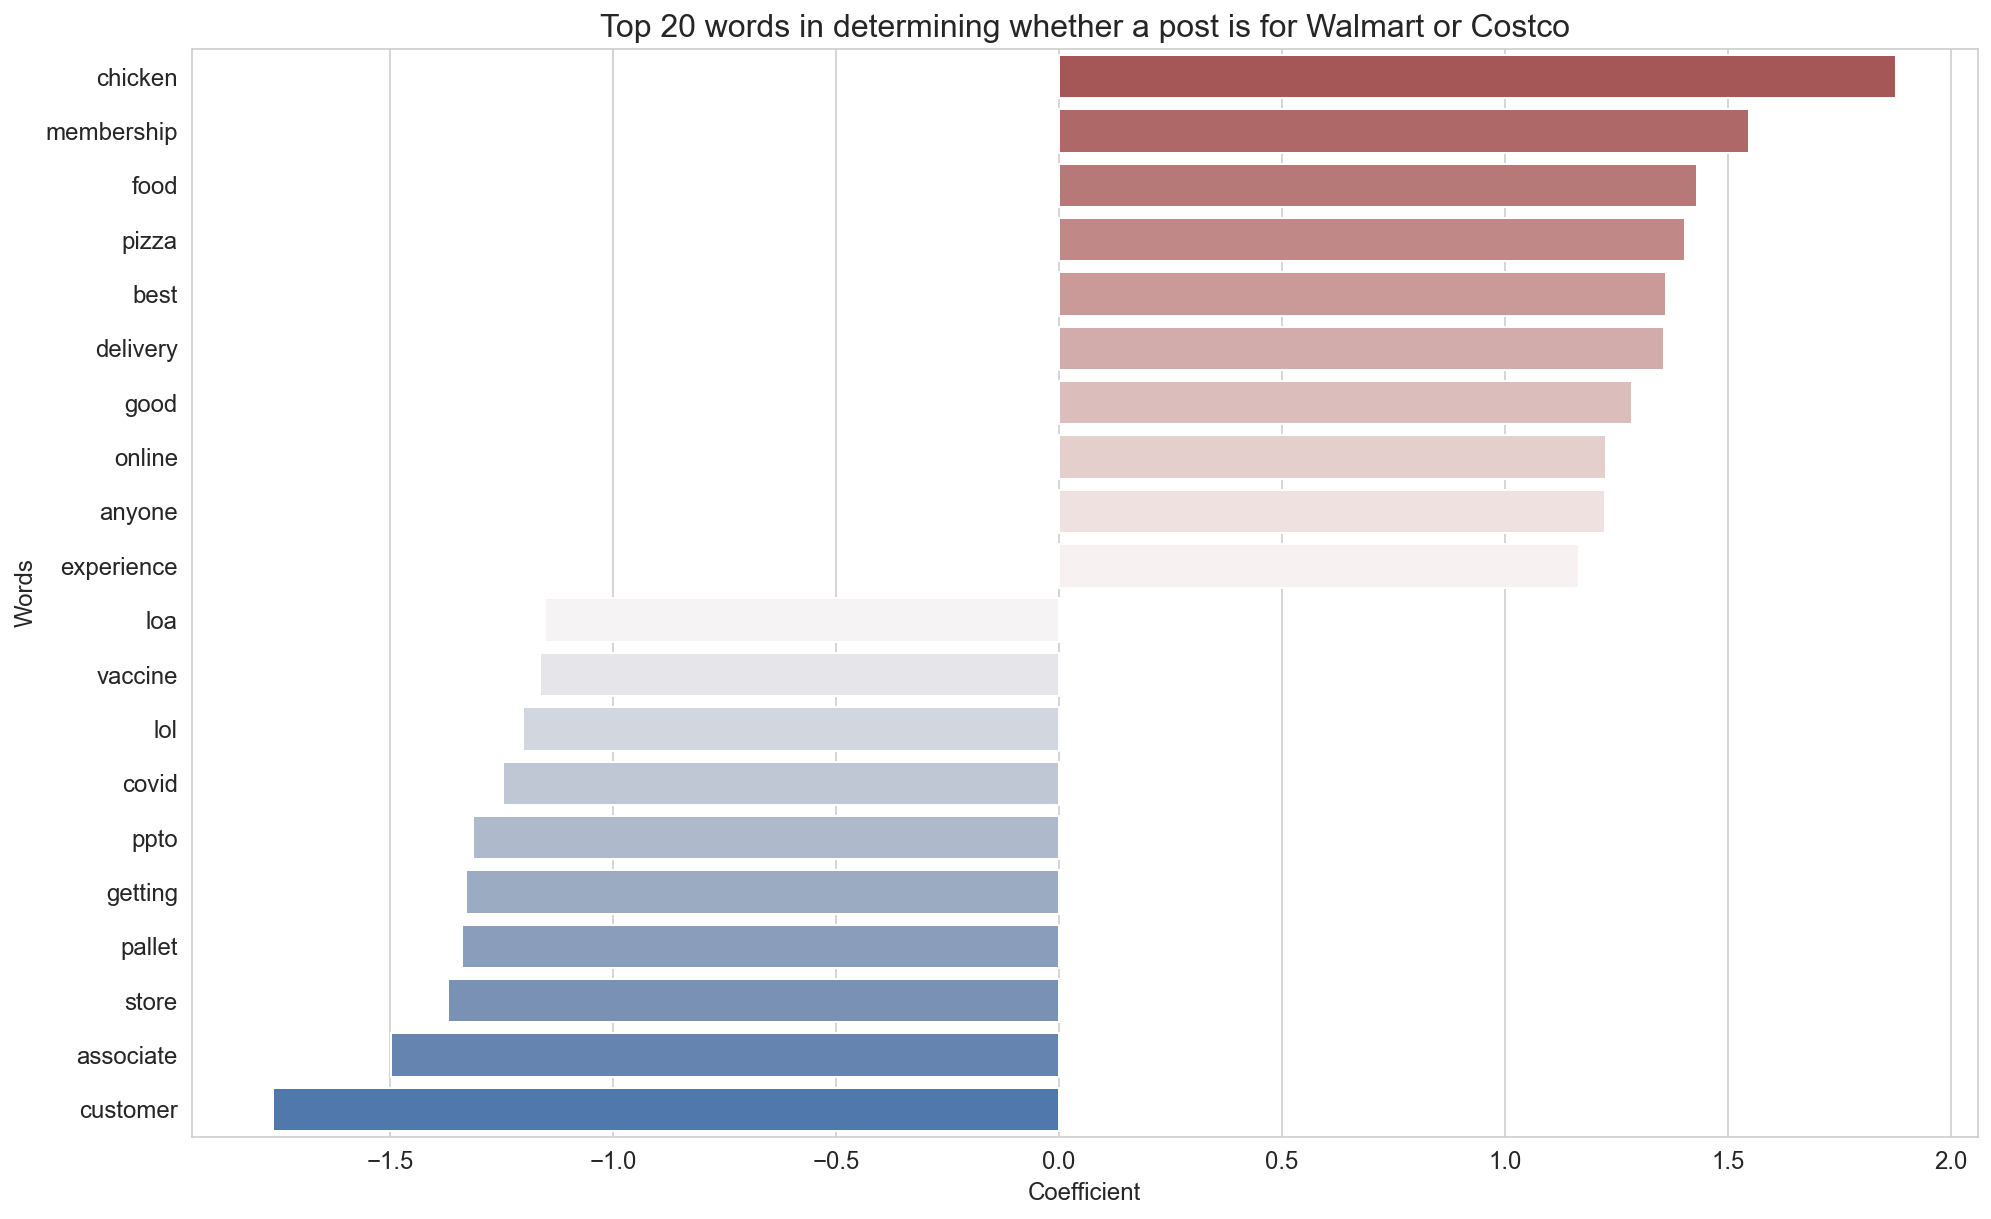

In [53]:
# visualise the top 20 words predicting that a post is in Walmart vs Costco
top_coefficient_df = pd.concat([coefficient_df.head(10), coefficient_df.tail(10)])
plt.figure(figsize=(16,10))
sns.barplot(y='feature', x='coef', data=top_coefficient_df, palette='vlag_r')
sns.set(style='whitegrid')
plt.title('Top 20 words in determining whether a post is for Walmart or Costco', fontsize=16)
plt.tick_params(labelsize=12)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Words', fontsize=12)

**Examining the top 20 words that determine whether a post is for Walmart or Costco**
- Based on the chart above, the top 10 words that identify whether a post belongs to **Walmart** are (in the order of increasing importance): 
    - 'loa', 'vaccine', 'lol', 'covid', 'ppto', 'getting', 'pallet', 'store', 'associate', 'customer'.
    
    
- On the other hand, the top 10 words that identify whether a post belongs to **Costco** are (in the order of increasing importance): 
    - 'experience', 'anyone', 'online', 'good', 'delivery', 'best', 'pizza', 'food', 'membership', 'chicken'. 


Since we are keen to understand Walmart's brand image on Reddit, in comparison to Costco's, as well as identify positive and negative feedback from Reddit users regarding both supermarkets, we will conduct a Sentiment Analysis to determine the sentiment of the posts across both subreddits in the [next notebook](./04_sentiment_analysis_and_recommendations.ipynb). This will allow us to draw further insights on how the top 20 words have been derived for Walmart and Costco, specifically for the Walmart subreddit which has revealed hints on the employee experience. 